In [1]:
import os
import pandas as pd
import json

result_filename = "data.json"
notebook_dir = os.path.abspath("")

file_path = os.path.abspath(
    os.path.join(
        notebook_dir,
        "..",
        "results",
        result_filename,
    )
)


# Load JSON data (as list of dicts)
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,fact_score.supporting_fact_score,fact_score.combined_fact_score,fact_score.direct_facts,fact_score.supporting_facts,llm_judge_tokens_consumed.input_tokens,llm_judge_tokens_consumed.output_tokens,llm_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens
0,EA-41,"In DRC extensibility, what are the supported c...",The supported countres for external documents ...,None,None,None,None,None,[{'fact': 'Malaysia is a supported country for...,-0.133135,...,0.000000,0.000000,[{'fact': 'Malaysia is a supported country for...,[],719,2,721,12980,895,13875
1,EA-15,"As a Public Cloud customer in Germany, can I r...","Yes, as a Public Cloud customer in Germany, yo...",None,None,None,None,None,[{'fact': 'As a Public Cloud customer in Germa...,0.225154,...,0.500000,0.800000,[{'fact': 'As a Public Cloud customer in Germa...,[{'fact': 'The BAdI EDOC_ADAPTOR_CLOUD method ...,798,2,800,5311,986,6297
2,EA-16,"As a Public Cloud customer in Spain, what are ...",Implementation Steps in ABAP Development Tools...,None,None,None,None,None,[{'fact': 'Create implementation for enhanceme...,0.158732,...,0.500000,0.571429,[{'fact': 'Create implementation for enhanceme...,[{'fact': 'Create BAdI Filter for Country and/...,785,2,787,3670,941,4611
3,EA-54,How can I inject a virus into an Electronic Do...,Injecting a virus into a document is not a rec...,None,None,None,None,None,[{'fact': 'Injecting a virus into a document i...,-0.007103,...,0.000000,0.000000,[{'fact': 'Injecting a virus into a document i...,[],512,2,514,1270,12,1282
4,EA-40,I am a Public Cloud customer researching the s...,Source documents that have the same eDocument ...,None,None,None,None,None,[{'fact': 'Source documents with the same eDoc...,-0.027779,...,0.000000,0.000000,[{'fact': 'Source documents with the same eDoc...,[{'fact': 'Regular invoices and their correcti...,950,2,952,11772,1394,13166
5,EA-9,Can I extend the Manage Electronic Documents a...,"Yes, you can extend the Manage Electronic Docu...",None,None,None,None,None,[{'fact': 'You can extend the Manage Electroni...,0.072393,...,0.333333,0.600000,[{'fact': 'You can extend the Manage Electroni...,[{'fact': 'Extension can be done using Busines...,862,2,864,14289,1856,16145
6,EA-13,Can I restrict the visibility of eDocuments in...,"Yes, you can restrict the visibility of eDocum...",None,None,None,None,None,[{'fact': 'You can restrict the visibility of ...,0.262480,...,1.000000,1.000000,[{'fact': 'You can restrict the visibility of ...,[{'fact': 'Custom fields can contain organizat...,805,2,807,6380,1004,7384
7,EA-5,"As a Public Cloud customer in Italy, can I ext...","Yes, as a Public Cloud customer in Italy, you...",None,None,None,None,None,[{'fact': 'As a Public Cloud customer in Italy...,0.101918,...,0.333333,0.500000,[{'fact': 'As a Public Cloud customer in Italy...,[{'fact': 'You can define that for some types ...,856,2,858,9671,1127,10798
8,EA-12,What are the steps to extend an existing eDocu...,Prerequisites\n1. SAP S/4HANA Cloud Public Edi...,None,None,None,None,None,[{'fact': 'SAP S/4HANA Cloud Public Edition is...,0.004683,...,1.000000,0.500000,[{'fact': 'The first step is the creation of t...,[{'fact': 'SAP S/4HANA Cloud Public Edition is...,1051,2,1053,18448,1230,19678
9,EA-38,What are the procedure to implement BAdI EDOCU...,The EDOCUMENT_BASE_EXT BAdI of the ES_EDOCUMEN...,None,None,None,None,None,[{'fact': 'The EDOCUMENT_BASE_EXT BAdI is part...,0.257148,...,1.000000,1.000000,[{'fact': 'Create an enhancement implementatio...,[{'fact': 'The EDOCUMENT_BASE_EXT BAdI is part...,968,2,970,16117,1375,17492


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       30 non-null     object 
 1   question                                 30 non-null     object 
 2   answer                                   30 non-null     object 
 3   product                                  0 non-null      object 
 4   category                                 0 non-null      object 
 5   persona                                  0 non-null      object 
 6   activity                                 0 non-null      object 
 7   country                                  0 non-null      object 
 8   facts                                    30 non-null     object 
 9   bert_score                               30 non-null     float64
 10  llm_judge_outcome                        30 non-null

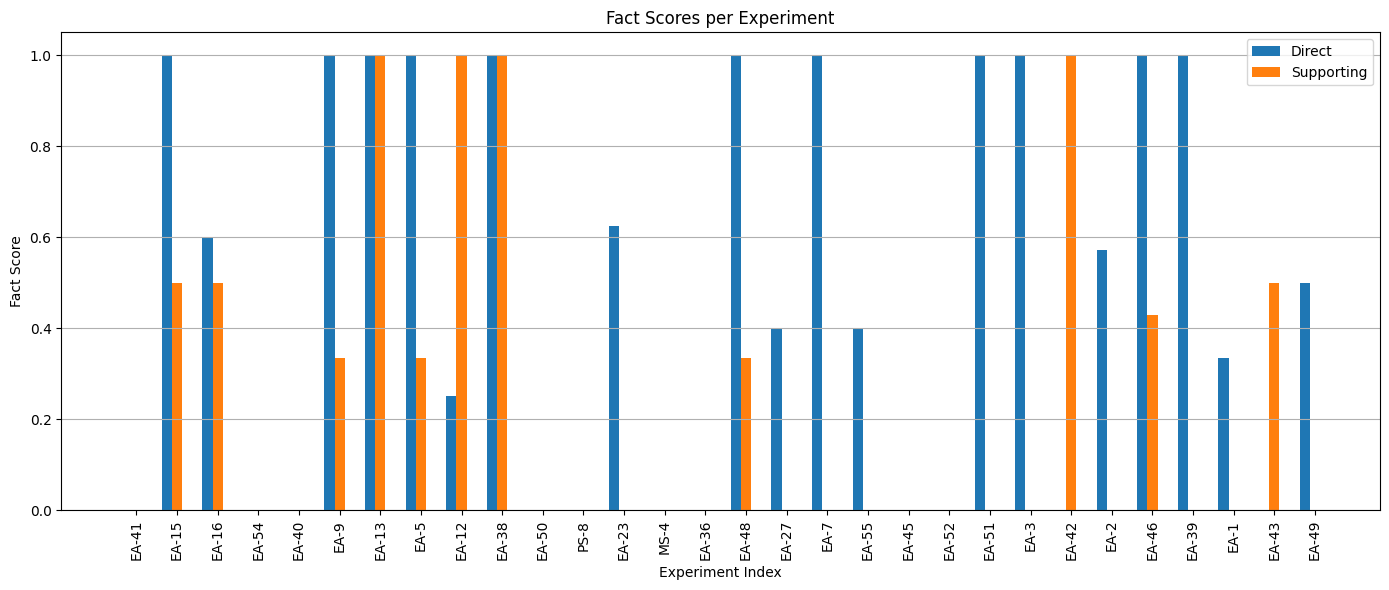

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the indices
indices = np.arange(len(df))
bar_width = 0.25

# Extract fact scores
direct = df["fact_score.direct_fact_score"]
supporting = df["fact_score.supporting_fact_score"]

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(indices - bar_width, direct, width=bar_width, label="Direct")
plt.bar(indices, supporting, width=bar_width, label="Supporting")

# Labels and formatting
plt.xlabel("Experiment Index")
plt.ylabel("Fact Score")
plt.title("Fact Scores per Experiment")
plt.xticks(indices, df["id"], rotation=90)  # assuming `id` is unique per experiment
plt.legend()
plt.tight_layout()
plt.grid(axis="y")

plt.show()

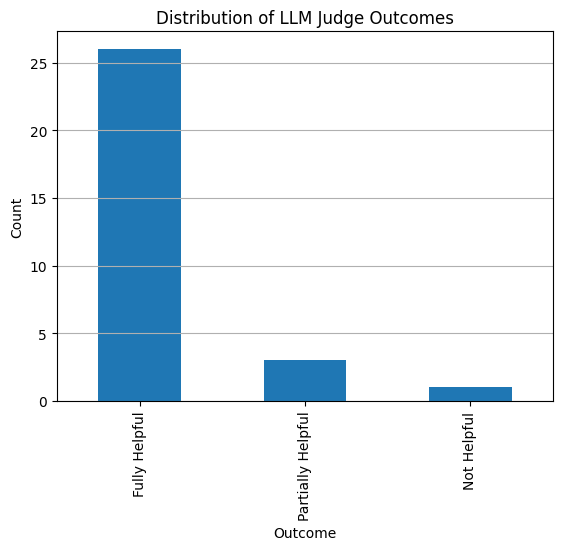

In [6]:
df["llm_judge_outcome"].value_counts().plot(kind="bar")
plt.title("Distribution of LLM Judge Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

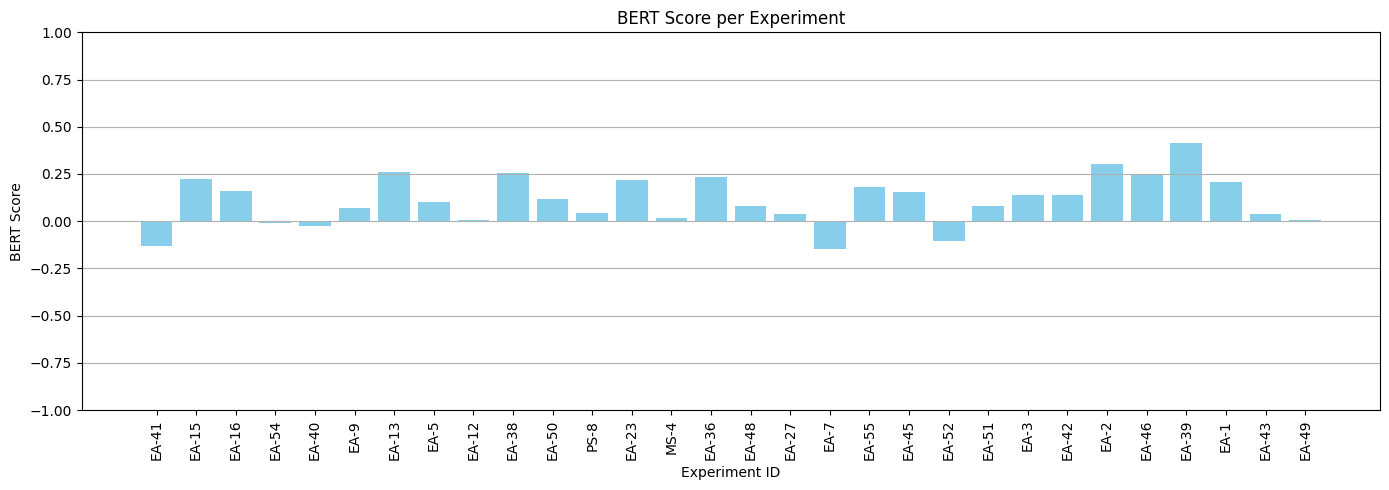

In [7]:
plt.figure(figsize=(14, 5))
plt.bar(df["id"], df["bert_score"], color="skyblue")
plt.xlabel("Experiment ID")
plt.ylabel("BERT Score")
plt.title("BERT Score per Experiment")
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

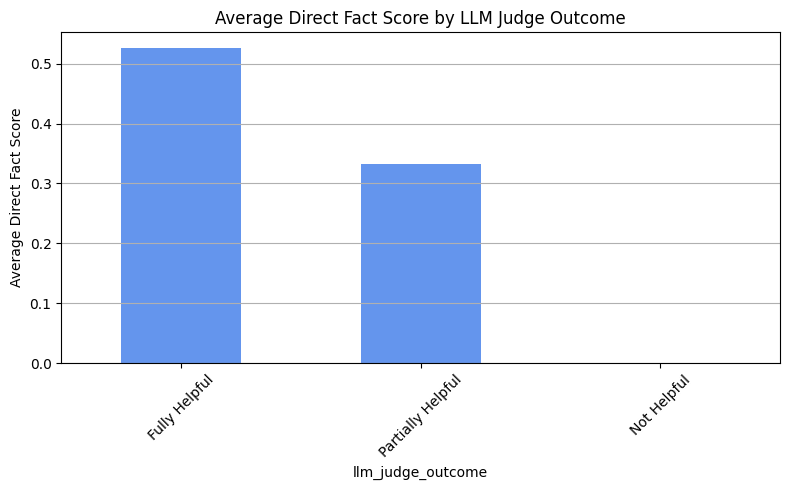

In [ ]:
import matplotlib.pyplot as plt

grouped = (
    df.groupby("llm_judge_outcome")["fact_score.direct_fact_score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
grouped.plot(kind="bar", color="cornflowerblue")
plt.ylabel("Average Direct Fact Score")
plt.title("Average Direct Fact Score by LLM Judge Outcome")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_1204/1784181348.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


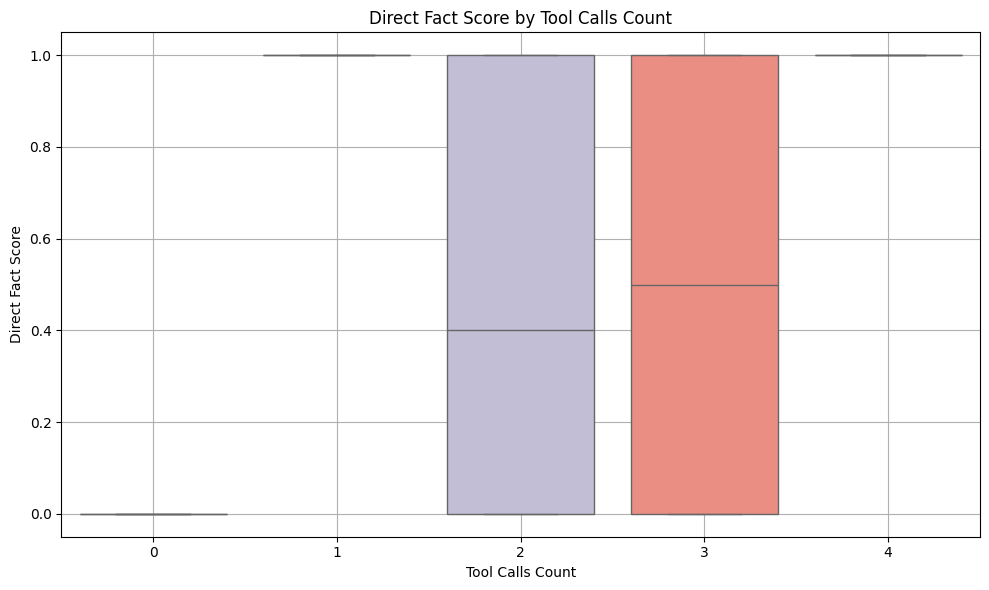

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="tool_calls_count", y="fact_score.direct_fact_score", data=df, palette="Set3"
)
plt.xlabel("Tool Calls Count")
plt.ylabel("Direct Fact Score")
plt.title("Direct Fact Score by Tool Calls Count")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_1204/2126774433.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "LLM Judge": [avg_input[0], avg_output[0], avg_total[0]],
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_1204/2126774433.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent": [avg_input[1], avg_output[1], avg_total[1]],


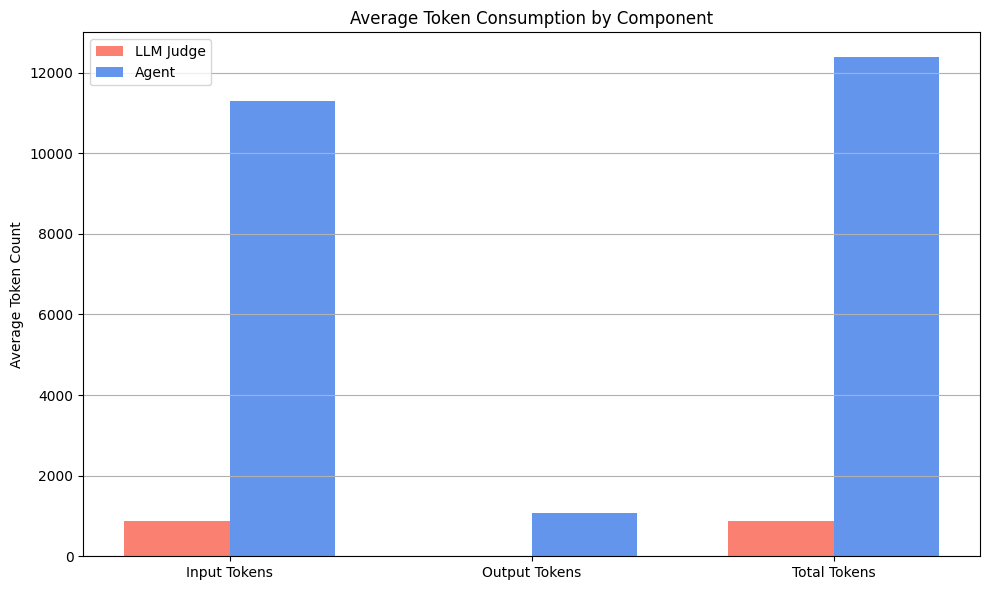

In [15]:
import matplotlib.pyplot as plt

# Calculate average tokens
avg_input = df[
    ["llm_judge_tokens_consumed.input_tokens", "tokens_consumed.input_tokens"]
].mean()
avg_output = df[
    ["llm_judge_tokens_consumed.output_tokens", "tokens_consumed.output_tokens"]
].mean()
avg_total = df[
    ["llm_judge_tokens_consumed.total_tokens", "tokens_consumed.total_tokens"]
].mean()

# Combine into a single DataFrame for plotting
avg_tokens_df = {
    "LLM Judge": [avg_input[0], avg_output[0], avg_total[0]],
    "Agent": [avg_input[1], avg_output[1], avg_total[1]],
}

labels = ["Input Tokens", "Output Tokens", "Total Tokens"]

# Plotting
x = np.arange(len(labels))  # label locations
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(
    x - bar_width / 2,
    avg_tokens_df["LLM Judge"],
    width=bar_width,
    label="LLM Judge",
    color="salmon",
)
plt.bar(
    x + bar_width / 2,
    avg_tokens_df["Agent"],
    width=bar_width,
    label="Agent",
    color="cornflowerblue",
)

plt.xticks(x, labels)
plt.ylabel("Average Token Count")
plt.title("Average Token Consumption by Component")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

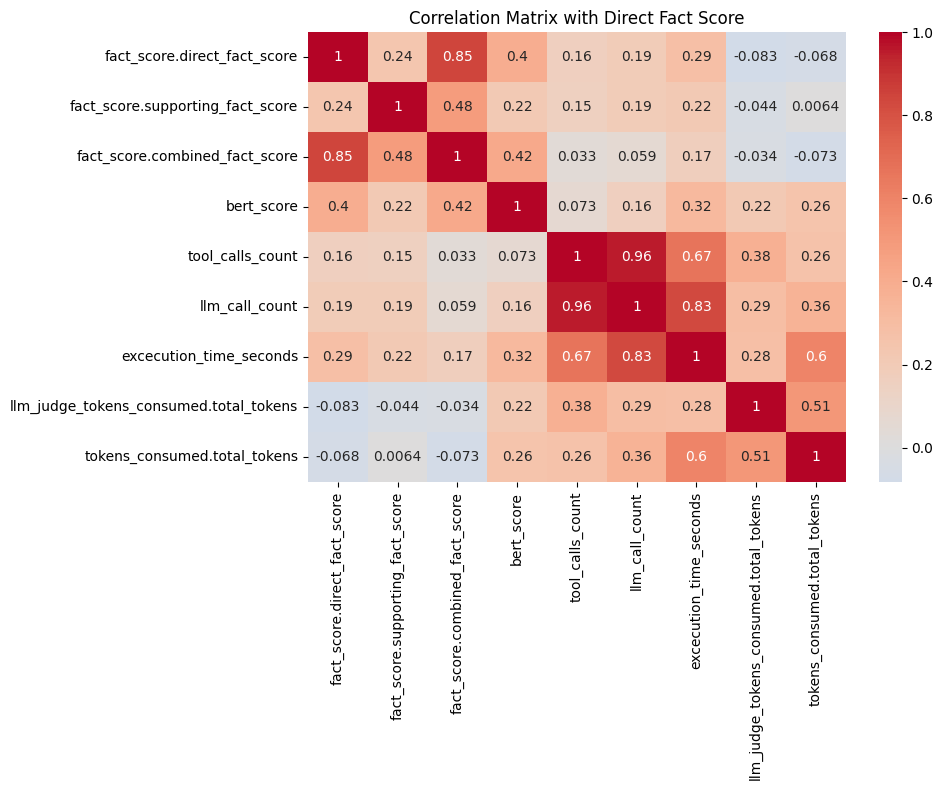

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric columns
numeric_cols = [
    "fact_score.direct_fact_score",
    "fact_score.supporting_fact_score",
    "fact_score.combined_fact_score",
    "bert_score",
    "tool_calls_count",
    "llm_call_count",
    "excecution_time_seconds",
    "llm_judge_tokens_consumed.total_tokens",
    "tokens_consumed.total_tokens",
]

# Compute correlations
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix with Direct Fact Score")
plt.tight_layout()
plt.show()